# Checking the results of a random orchestrated CNN

In [1]:

# Implement googlenetsmall
# Build an inception module
# get_ipython().run_line_magic('pip', 'install sqlalchemy')

DIM = 512

# In[2]:


import functools
import keras

DefaultConv = functools.partial(
    keras.layers.Conv2D, kernel_size=(3, 3), strides=(2, 2),
    padding="same", activation="relu")


# In[4]:


DefaultMaxPool = functools.partial(
    keras.layers.MaxPool2D,
    pool_size=(3,3), strides=(2,2), padding="same")

def get_model(input_shape, num_classes, use_batch_norm=True, **kwargs):
  model = keras.Sequential(**kwargs)
  model.add(keras.layers.Input(shape=input_shape))
  model.add(DefaultConv(filters=24, kernel_size=(5,5), strides=(2,2),  padding='same'))
  if use_batch_norm:
    model.add(keras.layers.BatchNormalization())
  model.add(DefaultMaxPool())
  model.add(keras.layers.Dropout(0.25))
  model.add(DefaultConv(filters=32))
  model.add(DefaultConv(filters=48))
  if use_batch_norm:
    model.add(keras.layers.BatchNormalization())
  model.add(DefaultMaxPool())
  model.add(DefaultConv(filters=64))

  model.add(keras.layers.GlobalAveragePooling2D())
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=128, activation="relu"))
  model.add(keras.layers.Dense(units=num_classes, activation='sigmoid'))

  return model


# In[5]:


model = get_model(input_shape=(DIM,DIM,3), num_classes=4, use_batch_norm=True)
model.summary()


# In[6]:


def iou(y_true, y_pred):
    """
    Calculate IoU loss between the true and predicted bounding boxes.

    y_true and y_pred should have the shape (batch_size, 4), where each element is
    [center_x, center_y, width, height].
    """
    # Convert (center_x, center_y, width, height) to (xmin, ymin, xmax, ymax)
    true_xmin = y_true[..., 0] - 0.5 * y_true[..., 2]
    true_ymin = y_true[..., 1] - 0.5 * y_true[..., 3]
    true_xmax = y_true[..., 0] + 0.5 * y_true[..., 2]
    true_ymax = y_true[..., 1] + 0.5 * y_true[..., 3]

    pred_xmin = y_pred[..., 0] - 0.5 * y_pred[..., 2]
    pred_ymin = y_pred[..., 1] - 0.5 * y_pred[..., 3]
    pred_xmax = y_pred[..., 0] + 0.5 * y_pred[..., 2]
    pred_ymax = y_pred[..., 1] + 0.5 * y_pred[..., 3]

    # Calculate the intersection area
    inter_xmin = keras.ops.maximum(true_xmin, pred_xmin)
    inter_ymin = keras.ops.maximum(true_ymin, pred_ymin)
    inter_xmax = keras.ops.minimum(true_xmax, pred_xmax)
    inter_ymax = keras.ops.minimum(true_ymax, pred_ymax)

    inter_width = keras.ops.maximum(0.0, inter_xmax - inter_xmin)
    inter_height = keras.ops.maximum(0.0, inter_ymax - inter_ymin)
    intersection_area = inter_width * inter_height

    # Calculate the union area
    true_area = (true_xmax - true_xmin) * (true_ymax - true_ymin)
    pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)
    union_area = true_area + pred_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou



# In[7]:


# Compile the model with IoU loss
# model.compile(optimizer='adam', loss=keras.losses.Huber(), metrics=[iou_loss])
model.compile(optimizer='adam', loss='mse', metrics=[iou])


# In[ ]:


from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from FrameLoader import FrameLoader
from DataGeneratorFrames import DataGeneratorFrames
from DataRepository import DataRepository

repo = DataRepository()
repo.load_relativePaths_of_videos_with_framelabels()

train_generator = DataGeneratorFrames(
    frameloader=FrameLoader(repo),
    train_test_val="train",
    dim=(DIM,DIM),
    batch_size=32,
)

val_generator = DataGeneratorFrames(
    frameloader=FrameLoader(repo),
    train_test_val="test",
    dim=(DIM,DIM),
    batch_size=32,
)


model.load_weights("randomModel.weights.h5")



2025-01-07 17:52:21.678765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 17:52:21.689207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736268741.701679  982456 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736268741.705392  982456 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 17:52:21.719495: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 24)   │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,476 (232.33 KB)

 Trainable params: 59,332 (231.77 KB)

 Non-trainable params: 144 (576.00 B)

connection established
connection established
DataGeneratorSkillBorders init done
connection established
DataGeneratorSkillBorders init done


/home/miked/code/judge/computervision/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
X, y = val_generator.__getitem__(2)
X_int, y = val_generator.__getitem__(2, normalize=False)
predictions = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [23]:
predictions[:5]

array([[0.50926125, 0.5674517 , 0.32012784, 0.19659257],
       [0.49681765, 0.57237285, 0.32272446, 0.1952453 ],
       [0.5057631 , 0.5456485 , 0.30535737, 0.19567294],
       [0.5035784 , 0.5389652 , 0.27505574, 0.16584268],
       [0.49351302, 0.57286847, 0.32404947, 0.1968501 ]], dtype=float32)

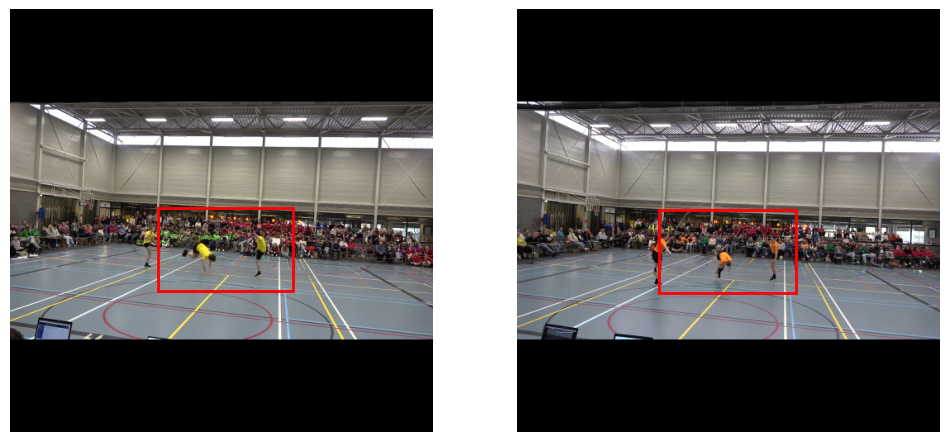

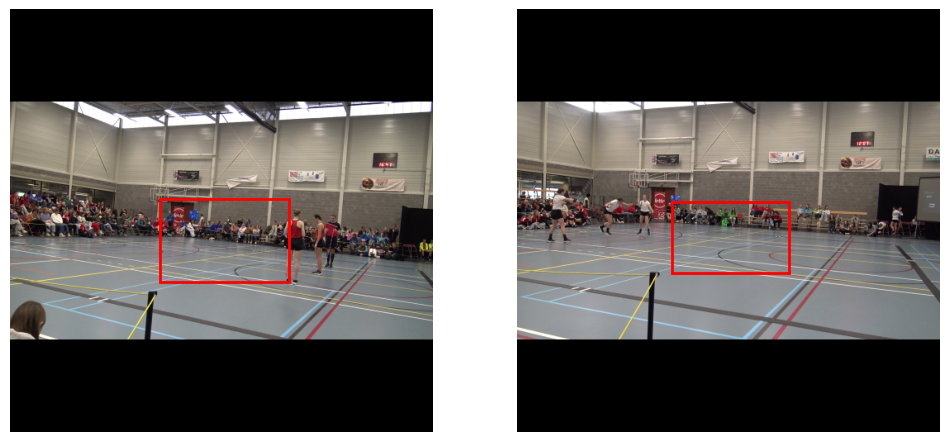

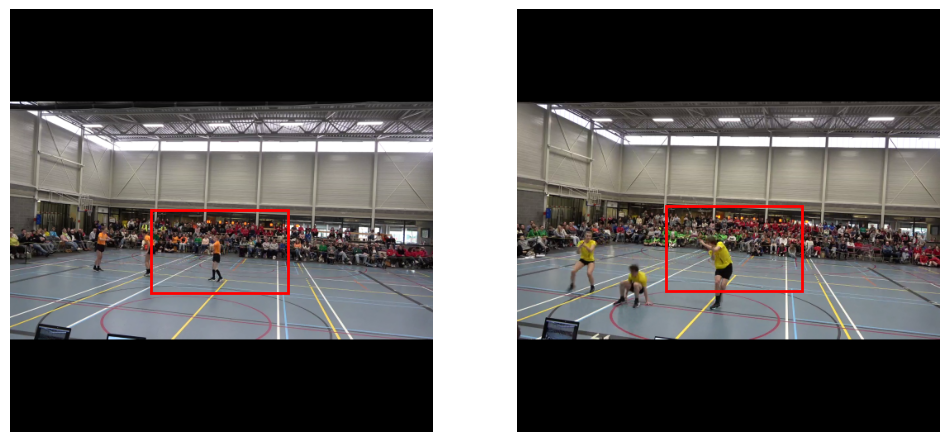

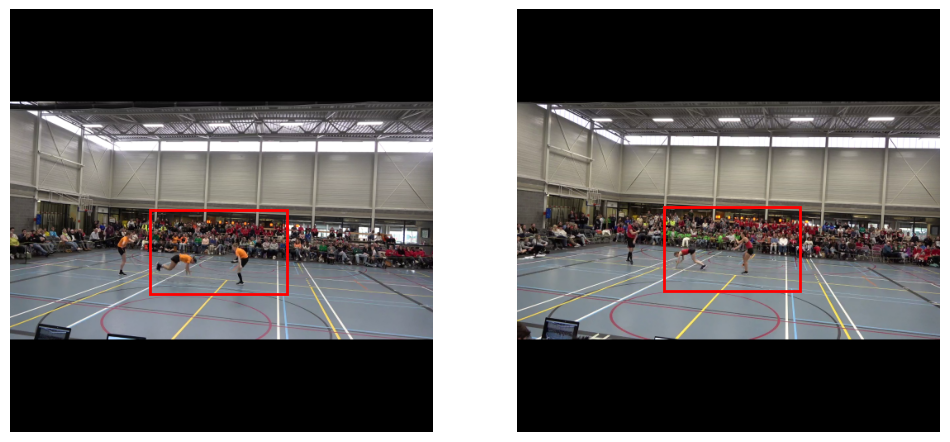

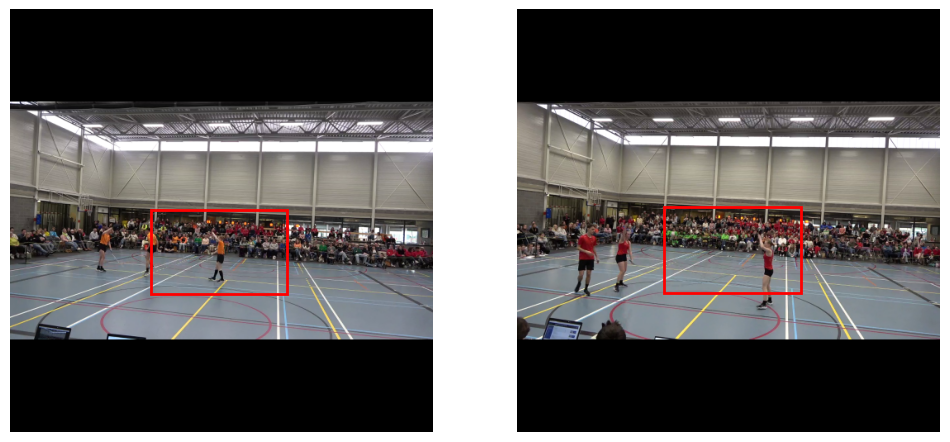

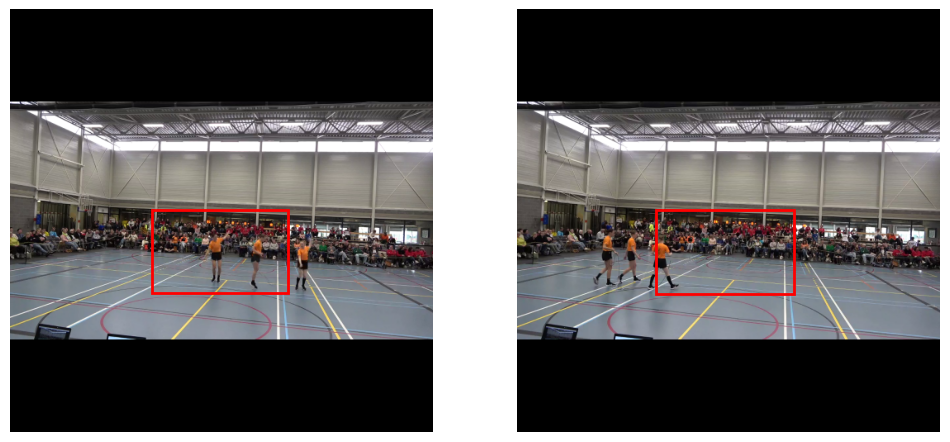

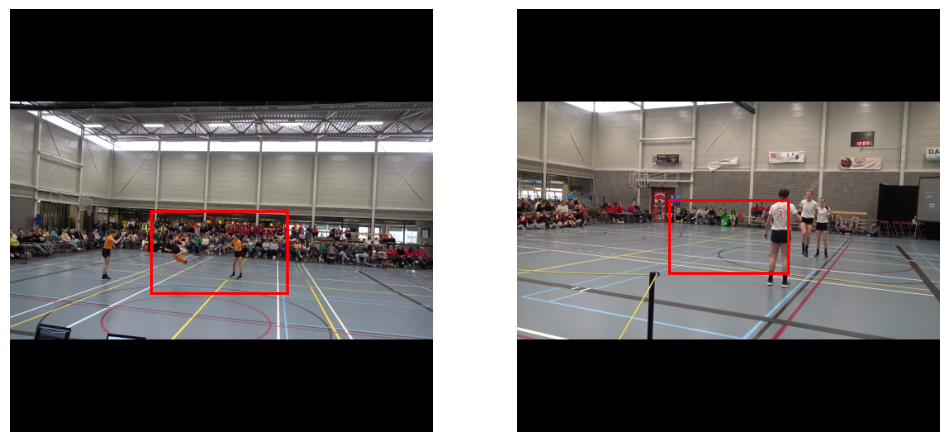

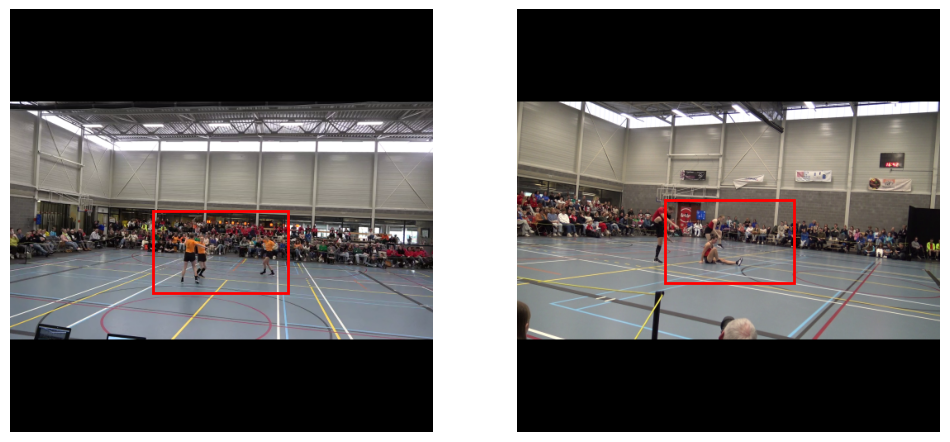

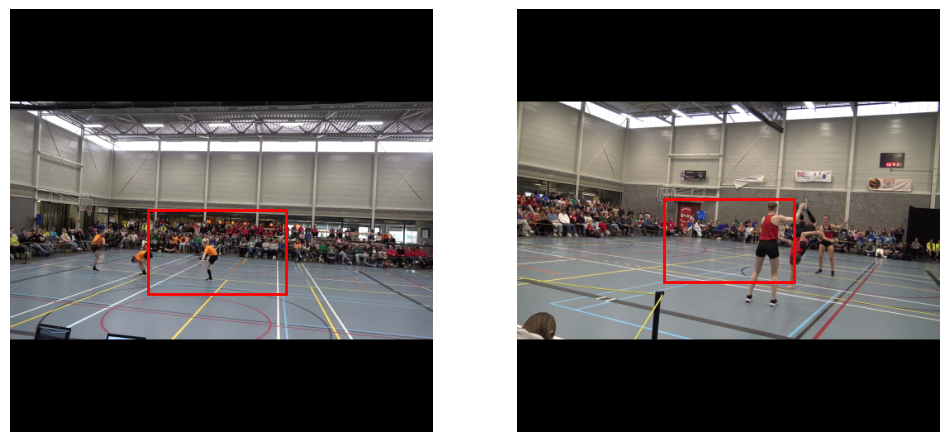

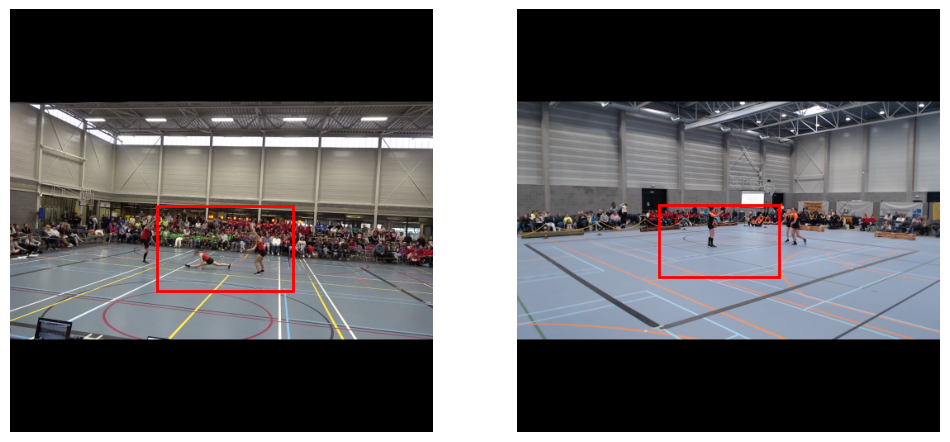

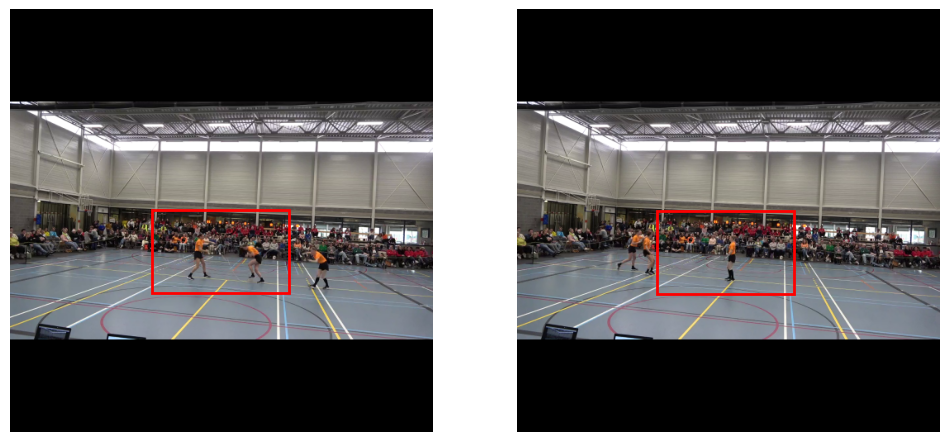

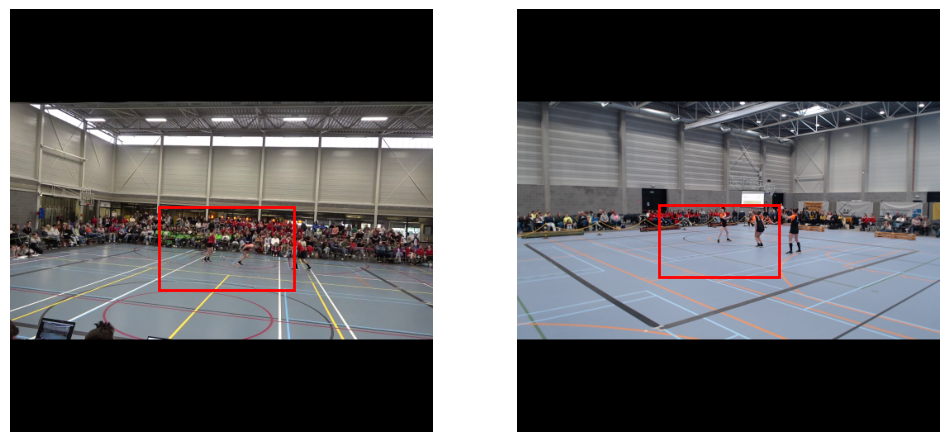

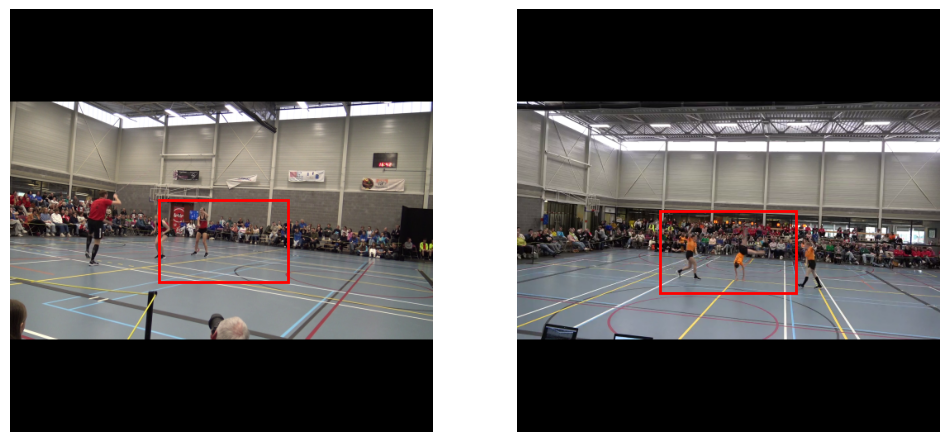

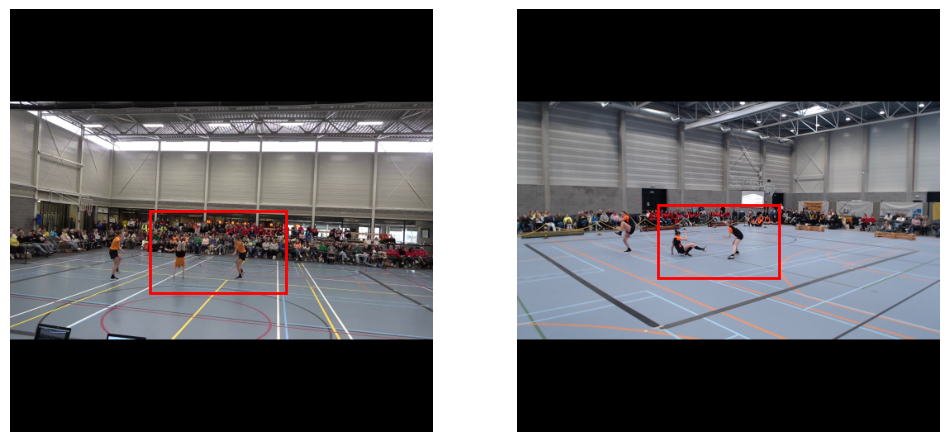

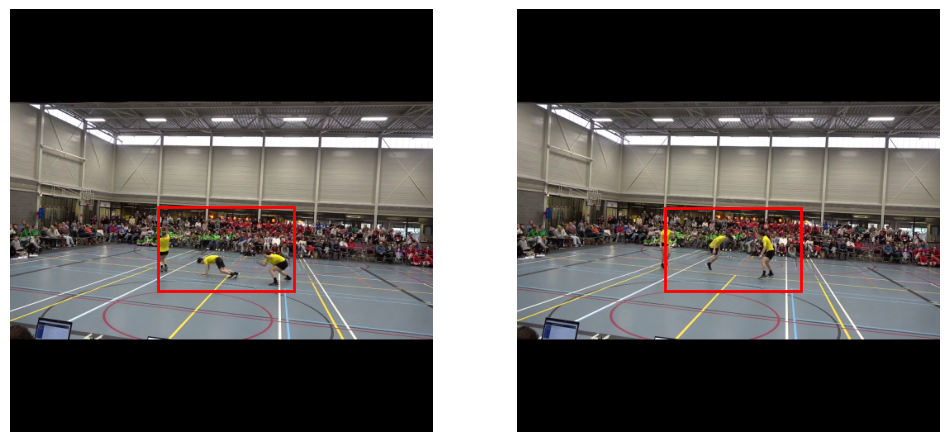

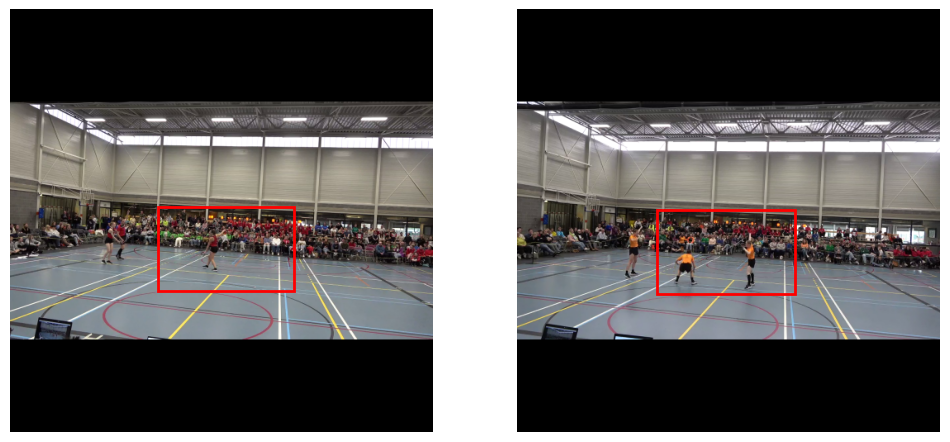

In [24]:
from helpers import plot
for j in range(len(X_int)//2):
    plot(X_int[j*2:j*2+2], predictions[j*2:j*2+2])

In [15]:
len(X)//2

16